In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from numba import njit

import neal

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import Classic_SVM_CVXOPT_Linear as CL
import Classic_SVM_CVXOPT_Gaussian as CG
import Quantum_SVM_Linear_neal as QL
import Quantum_SVM_Gaussian_neal as QG

In [ ]:
#데이터 및 상수 생성

n_train = 50

X, Y = make_circles(n_samples = 200, noise=0.1, random_state = 40)
X_train = X[:n_train, :]
X_test = X[n_train:, :]
y_train = Y[:n_train] 
y_test = Y[n_train:]

y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

N_train = X_train.shape[0]

In [ ]:
# B_list = [5]*30

# K_list = [3]*30

# xi_list = [1]*30

# gamma_list = [g/10 for g in range(30)]
# C_list = []

In [ ]:
B_list = [5]*30

K_list = [3]*30

xi_list = [1]*30

gamma_list = [1]*30
C_list = [10*c for c in range(300)]

In [ ]:
C_acc_list = []
C_auroc_list = []
C_auprc_list = []

Q_acc_Max = []
Q_auroc_Max = []
Q_auprc_Max = []

Qgap_acc_Max = []
Qgap_auroc_Max = []
Qgap_auprc_Max = []

Cgap_acc_list   = []
Cgap_auroc_list = []
Cgap_auprc_list = []

Qgap_acc_train_list = []
Qgap_auroc_train_list = []
Qgap_auprc_train_list = []

Qgap_acc_Max_list = []
Qgap_auroc_Max_list = []
Qgap_auprc_Max_list = []

C_Loss_train_mean = []
C_Loss_test_mean = []

Q_Loss_train_mean_Min = []
Q_Loss_test_mean_Min = []

nth_alpha = []
Sum_evaluate = []

In [ ]:
for i  in range(len(gamma_list)):
    
    B = B_list[i]
    K = K_list[i]
    xi = xi_list[i]
    gamma = gamma_list[i]
    C = 0

    Q_acc_train_list = []
    Q_auroc_train_list = []
    Q_auprc_train_list = []

    Q_acc_test_list = []
    Q_auroc_test_list = []
    Q_auprc_test_list = []

    Qgap_acc_list = []
    Qgap_auroc_list = []
    Qgap_auprc_list = []

    Q_Loss_train_mean = []
    Q_Loss_test_mean = []

    #Classic SVM
    for k in range(1,K+1):
        C += B**k

    P, q, G, h, A, b, K_train_train = CG.Solver_Parameter(N_train, X_train, y_train, gamma, C)
    sol = CG.Solver_SVM(P, q, G, h, A, b)

    alpha = np.array(sol['x']).reshape(-1)

    acc_train, auroc_train, auprc_train, C_scores_train = CG.evaluate_train(
            y_train,
            alpha,
            K_train_train,
            C
        )

    acc_test, auroc_test, auprc_test = QG.evaluate_test(
        y_test,
        CG.Test_evlauation(X_train, X_test, y_train, alpha, K_train_train, gamma, C)
    )

    C_acc_list.append(acc_test)
    C_auroc_list.append(auroc_test)
    C_auprc_list.append(auprc_test)

    Cgap_acc, Cgap_auroc, Cgap_auprc = CG.Evaluate_Overfitting(acc_train, acc_test, auroc_train, auroc_test, auprc_train, auprc_test)
    Cgap_acc_list.append(Cgap_acc)
    Cgap_auroc_list.append(Cgap_auroc)
    Cgap_auprc_list.append(Cgap_auprc)

    Loss_train, Loss_test= CG.Hinge_Loss(X_train, X_test, y_train, y_test, alpha, K_train_train, C_scores_train, gamma, C)

    C_Loss_train_mean.append(Loss_train)
    C_Loss_test_mean.append(Loss_test)

    #Quantum SVM
    K_train_train, Q = QG.Q_metric(N_train, X_train, y_train, B, K, xi, gamma)

    sol = QG.neal_Solver(Q)

    top_k = len(sol)
    if top_k > 20:
        top_k = 20 

    for n_th in range(top_k):

        x_opt, energy = QG.Solution(sol, top_k, n_th)

        alpha = QG.alpha_value(N_train, x_opt, B, K)

        Q_acc_train, Q_auroc_train, Q_auprc_train, Q_scores_train = QG.evaluate_train(
            y_train,
            alpha,
            K_train_train,
            C
        )

        Q_acc_test, Q_auroc_test, Q_auprc_test = QG.evaluate_test(
            y_test,
            QG.Test_evlauation(X_train, X_test, y_train, alpha, K_train_train, gamma, C)
        )

        Q_acc_train_list.append(Q_acc_train)
        Q_auroc_train_list.append(Q_auroc_train)
        Q_auprc_train_list.append(Q_auprc_train)

        Q_acc_test_list.append(Q_acc_test)
        Q_auroc_test_list.append(Q_auroc_test)
        Q_auprc_test_list.append(Q_auprc_test)

        Q_gap_acc, Q_gap_auroc, Q_gap_auprc = QG.Evaluate_Overfitting(Q_acc_train, Q_acc_test, Q_auroc_train, Q_auroc_test, Q_auprc_train, Q_auprc_test)

        Qgap_acc_list.append(Q_gap_acc)
        Qgap_auroc_list.append(Q_gap_auroc)
        Qgap_auprc_list.append(Q_gap_auprc)

        Loss_train, Loss_test= QG.Hinge_Loss(X_train, X_test, y_train, y_test, alpha, K_train_train, Q_scores_train, gamma, C)

        Q_Loss_train_mean.append(Loss_train)
        Q_Loss_test_mean.append(Loss_test)

    Q_acc_Max.append(max(Q_acc_test_list))
    Q_auroc_Max.append(max(Q_auroc_test_list))
    Q_auprc_Max.append(max(Q_auprc_test_list))
    
    Qgap_acc_Max.append(max(Qgap_acc_list))
    Qgap_auroc_Max.append(max(Qgap_auroc_list))
    Qgap_auprc_Max.append(max(Qgap_auprc_list))

    Q_Loss_train_mean_Min.append(min(Q_Loss_train_mean))
    Q_Loss_test_mean_Min.append(min(Q_Loss_test_mean))

     pcost       dcost       gap    pres   dres
 0: -3.9000e+03 -1.5500e+04  1e+04  1e-14  6e-14
 1: -5.9725e+03 -7.8275e+03  2e+03  6e-14  5e-14
 2: -7.7322e+03 -7.7710e+03  4e+01  2e-13  2e-13
 3: -7.7498e+03 -7.7502e+03  4e-01  2e-16  1e-13
 4: -7.7500e+03 -7.7500e+03  4e-03  6e-14  1e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2313e+03 -1.5573e+05  2e+05  9e-14  9e-14
 1: -1.1406e+03 -1.3223e+04  1e+04  4e-14  9e-14
 2: -2.7511e+03 -6.8288e+03  4e+03  6e-14  9e-14
 3: -3.4601e+03 -5.0330e+03  2e+03  3e-14  9e-14
 4: -3.8124e+03 -4.2371e+03  4e+02  9e-14  1e-13
 5: -3.9601e+03 -4.0696e+03  1e+02  6e-14  1e-13
 6: -3.9956e+03 -4.0194e+03  2e+01  3e-14  1e-13
 7: -4.0055e+03 -4.0069e+03  1e+00  1e-13  1e-13
 8: -4.0061e+03 -4.0061e+03  2e-02  3e-13  1e-13
 9: -4.0061e+03 -4.0061e+03  2e-04  9e-14  1e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.4217e+03 -2.2131e+05  2e+05  1e-13  8e-14
 1:  2.1634e+03 -2.8309e

<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
C:\Users\cotjq\AppData\Local\Temp\ipykernel_14140\3201586829.py:12: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_xlabel(u"${\gamma}$")
C:\Users\cotjq\AppData\Local\Temp\ipykernel_14140\3201586829.py:26: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel(u"${\gamma}$")


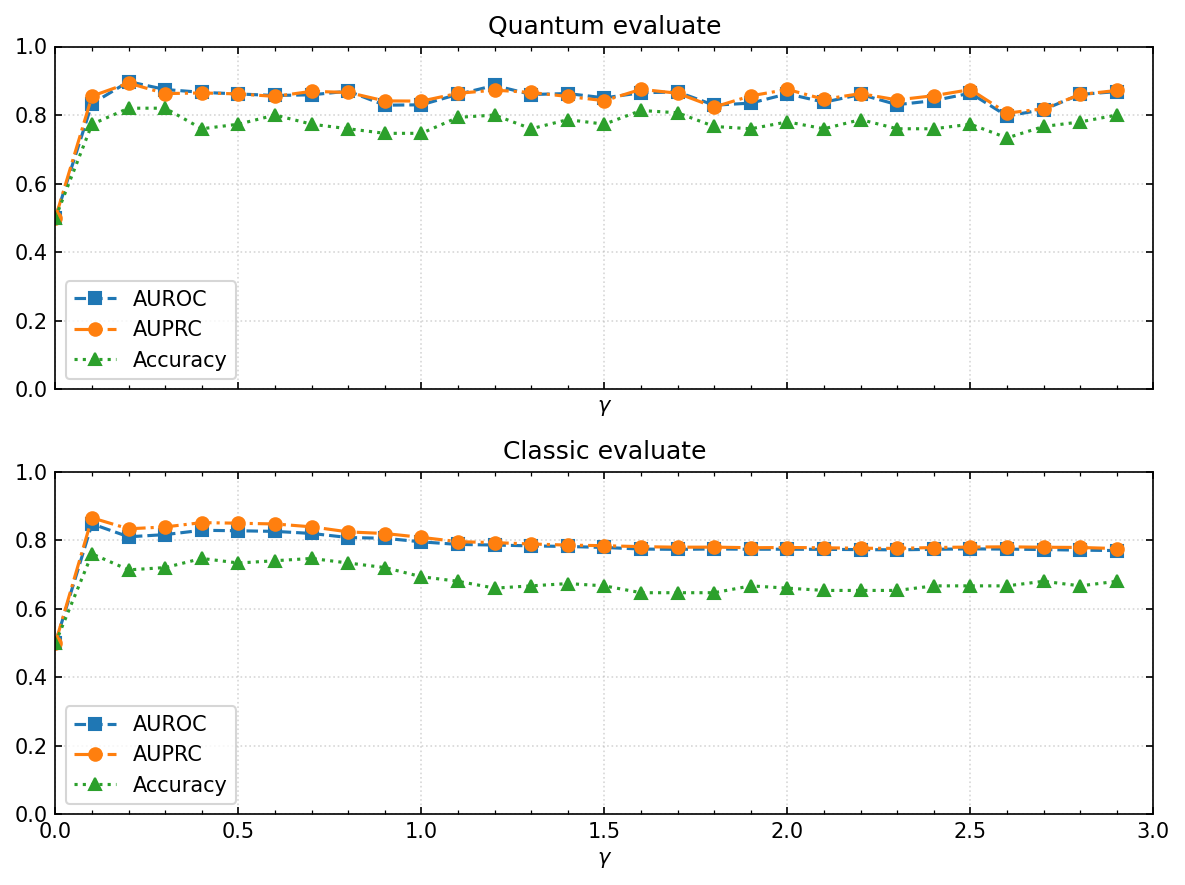

In [ ]:
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 6),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

axes[0].plot(gamma_list, Q_auroc_Max, 's--', label="AUROC")
axes[0].plot(gamma_list, Q_auprc_Max, 'o-.', label="AUPRC")
axes[0].plot(gamma_list, Q_acc_Max, '^:', label="Accuracy")
axes[0].set_title("Quantum evaluate")
axes[0].set_xlabel(u"${\gamma}$")
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, 3)
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[0].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[0].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].legend(loc = "lower left")

axes[1].plot(gamma_list, C_auroc_list, 's--', label="AUROC")
axes[1].plot(gamma_list, C_auprc_list, 'o-.', label="AUPRC")
axes[1].plot(gamma_list, C_acc_list, '^:', label="Accuracy")
axes[1].set_title("Classic evaluate")
axes[1].set_xlabel(u"${\gamma}$")
axes[1].set_ylim(0, 1)
axes[1].set_xlim(0, 3)
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[1].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[1].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[1].legend(loc = "lower left")

plt.tight_layout()

plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:38: SyntaxWarning: invalid escape sequence '\g'
<>:59: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:38: SyntaxWarning: invalid escape sequence '\g'
<>:59: SyntaxWarning: invalid escape sequence '\g'
C:\Users\cotjq\AppData\Local\Temp\ipykernel_14140\2479933867.py:17: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_xlabel(u"${\gamma}$")
C:\Users\cotjq\AppData\Local\Temp\ipykernel_14140\2479933867.py:38: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel(u"${\gamma}$")
C:\Users\cotjq\AppData\Local\Temp\ipykernel_14140\2479933867.py:59: SyntaxWarning: invalid escape sequence '\g'
  axes[2].set_xlabel(u"${\gamma}$")


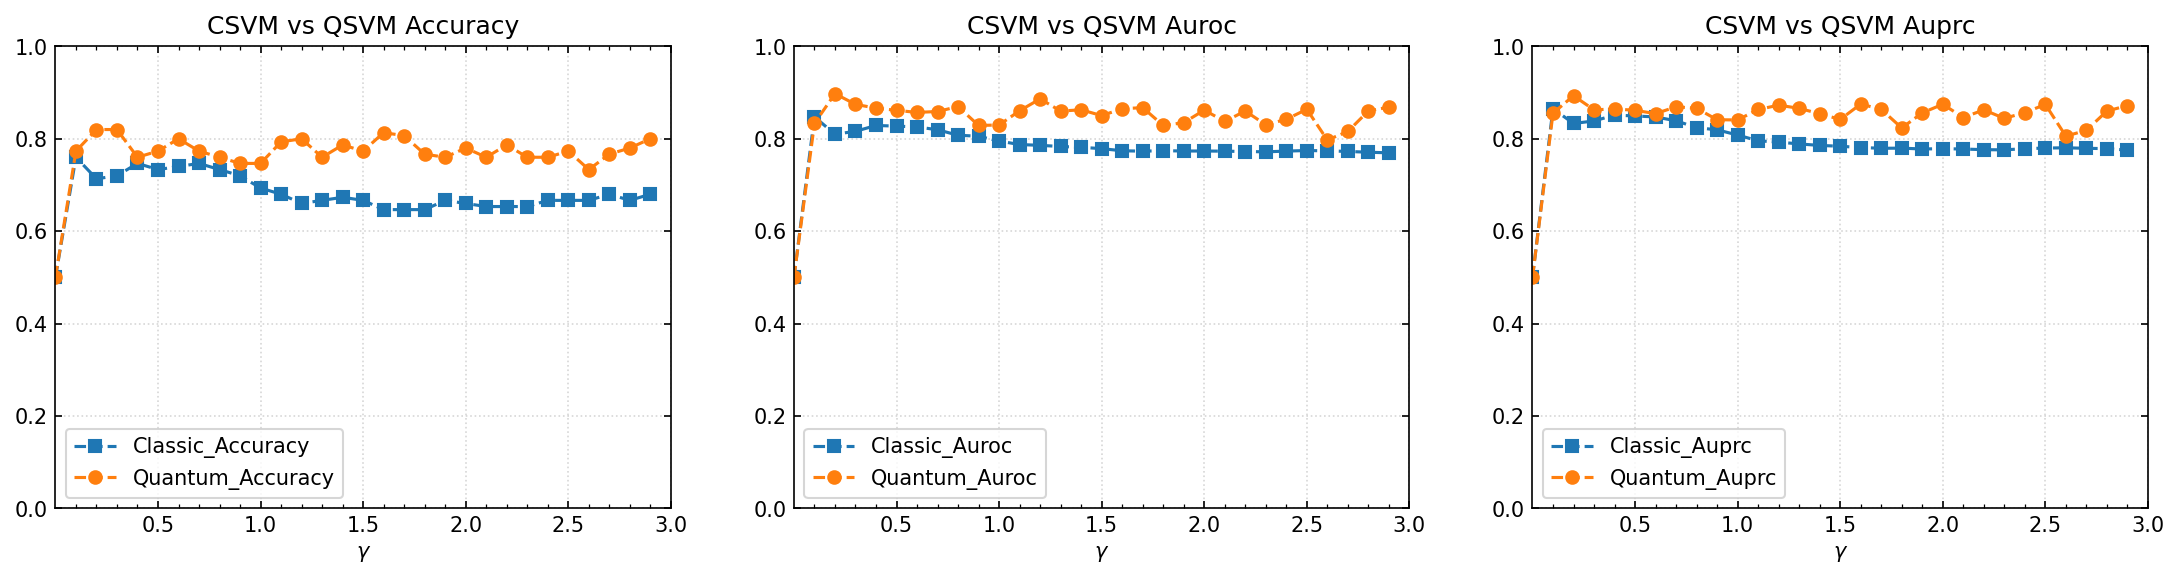

In [ ]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 4),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

axes[0].plot(gamma_list, C_acc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Accuracy")
axes[0].plot(gamma_list, Q_acc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Accuracy")
axes[0].set_title("CSVM vs QSVM Accuracy")
axes[0].set_xlabel(u"${\gamma}$")
axes[0].set_ylim(0, 1)
axes[0].set_xlim(1e-6, 3)
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[0].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[0].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].legend(loc = "lower left")

axes[1].plot(gamma_list, C_auroc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Auroc")

axes[1].plot(gamma_list, Q_auroc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Auroc")

axes[1].set_title("CSVM vs QSVM Auroc")
axes[1].set_xlabel(u"${\gamma}$")
axes[1].set_ylim(0, 1)
axes[1].set_xlim(1e-6, 3)
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[1].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[1].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[1].legend(loc = "lower left")

axes[2].plot(gamma_list, C_auprc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Auprc")

axes[2].plot(gamma_list, Q_auprc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Auprc")

axes[2].set_title("CSVM vs QSVM Auprc")
axes[2].set_xlabel(u"${\gamma}$")
axes[2].set_ylim(0, 1)
axes[2].set_xlim(1e-6, 3)
axes[2].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[2].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[2].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[2].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[2].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[2].legend(loc = "lower left")

In [ ]:
# axes[].set_xlim(0, 3)
# axes[].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
# axes[].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
# axes[].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
# axes[].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
# axes[].tick_params(axis='both', which='both', direction='in', top=True, right=True)

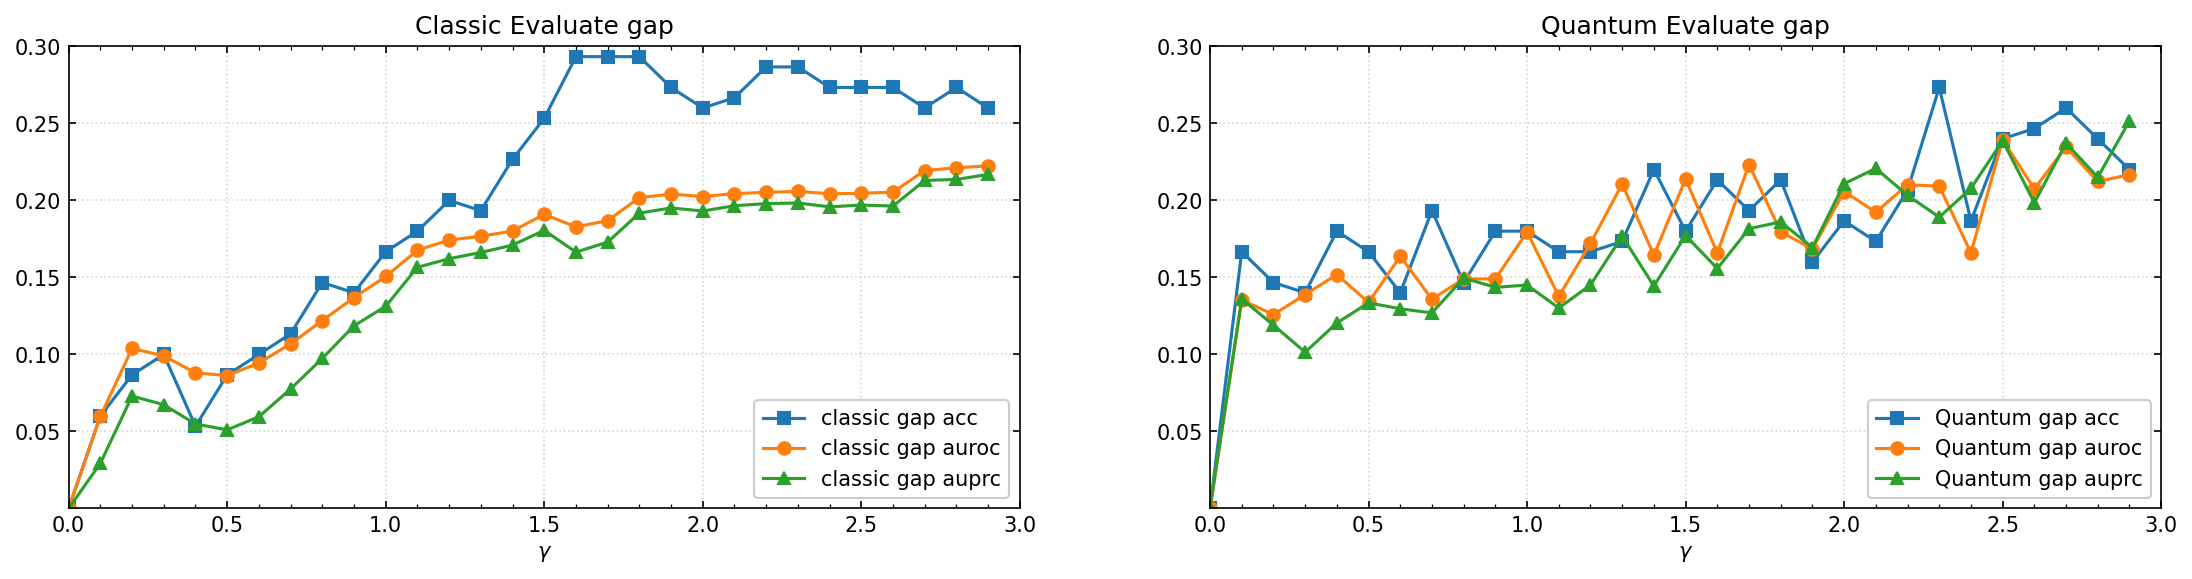

In [ ]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 4),
    dpi=150,
    sharex=True
)

# =========================
# 공통 x축 설정
# =========================
def setup_gamma_axis(ax):
    ax.set_xlim(0, 3)

    # ✔ 0.5 간격 → 큰 눈금 (major)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))

    # ✔ 0.1 간격 → 작은 눈금 (minor)
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))

    # (선택) 큰 눈금만 라벨 표시
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    # ✔ 격자는 큰 눈금 위치에만
    ax.grid(
        which='major',
        linestyle=':',
        linewidth=0.8,
        alpha=0.5
    )

    # ✔ 눈금: 위/아래/좌/우 + 안쪽
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True
    )

# =========================
# Left: Classic
# =========================
axes[0].plot(gamma_list, Cgap_acc_list, "s-", label="classic gap acc")
axes[0].plot(gamma_list, Cgap_auroc_list, "o-", label="classic gap auroc")
axes[0].plot(gamma_list, Cgap_auprc_list, "^-", label="classic gap auprc")

axes[0].set_title("Classic Evaluate gap")
axes[0].set_ylim(1e-6, 0.3)
axes[0].set_xlabel(r"$\gamma$")

setup_gamma_axis(axes[0])

axes[0].legend(loc="lower right", framealpha=1)

# =========================
# Right: Quantum
# =========================
axes[1].plot(gamma_list, Qgap_acc_Max, "s-", label="Quantum gap acc")
axes[1].plot(gamma_list, Qgap_auroc_Max, "o-", label="Quantum gap auroc")
axes[1].plot(gamma_list, Qgap_auprc_Max, "^-", label="Quantum gap auprc")

axes[1].set_title("Quantum Evaluate gap")
axes[1].set_ylim(1e-6, 0.3)
axes[1].set_xlabel(r"$\gamma$")

setup_gamma_axis(axes[1])

axes[1].legend(loc="lower right", framealpha=1)

plt.show()

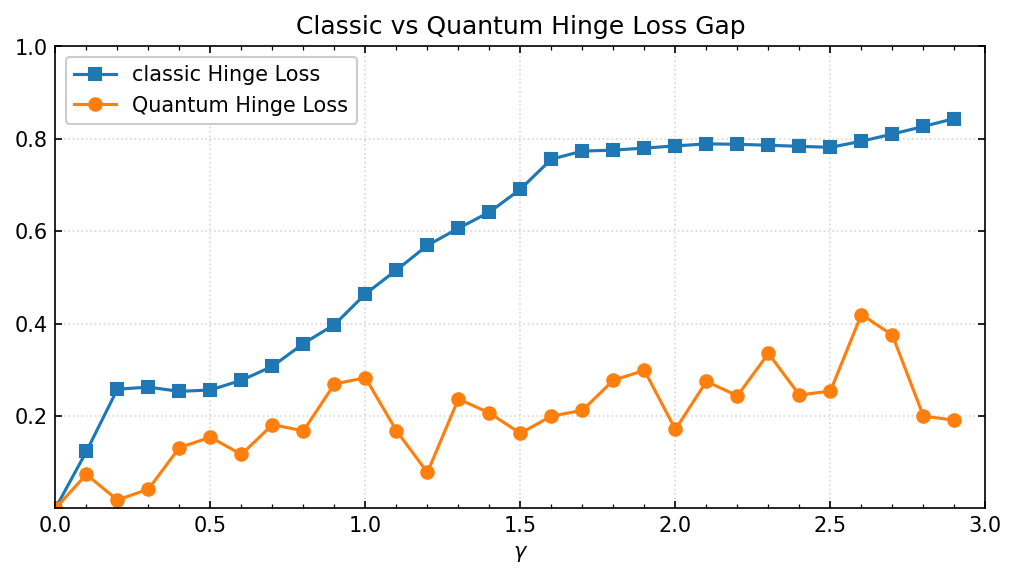

In [ ]:
C_Loss = [(C_Loss_test_mean[i] - C_Loss_train_mean[i]) for i in range(len(C_Loss_train_mean))]
Q_Loss = [(Q_Loss_test_mean_Min[i] - Q_Loss_train_mean_Min[i]) for i in range(len(Q_Loss_train_mean_Min))]

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

ax.plot(gamma_list, C_Loss, "s-", label="classic Hinge Loss")
ax.plot(gamma_list, Q_Loss, "o-", label="Quantum Hinge Loss")

ax.set_title("Classic vs Quantum Hinge Loss Gap")
ax.set_ylim(1e-6, 1)
ax.set_xlabel(r"$\gamma$")

# x축 범위 (0~3만 쓰는 거면 0~3만 남김)
ax.set_xlim(0, 3)

# x축: 0.5는 큰 눈금(major), 0.1은 작은 눈금(minor)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# 격자: 큰 눈금 위치에만, 점선, 투명도 50%
ax.grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)

# 위/오른쪽에도 눈금 + 안쪽 방향
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.legend(loc="upper left", framealpha=1)

plt.show()

In [ ]:
h = 0.01

x_min, x_max = X_test[:, 0].min()-1 , X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min()-1 , X_test[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]  # (N_grid, 2)

# grid에 대한 decision score f(x) 계산: f(x) = Σ α_i y_i k(x_i, x) + b
N_train = X_train.shape[0]
N_grid = grid.shape[0]

K_train_grid = np.zeros((N_train, N_grid))
for i in range(N_train):
    for j in range(N_grid):
        K_train_grid[i, j] = QG.Gaussian_kernel(i, j, gamma, X_train, grid)

scores_grid = (alpha * y_train) @ K_train_grid + QG.b_value(alpha, y_train, K_train_train, C)
Z = scores_grid.reshape(xx.shape)

plt.contourf(xx, yy, C_Z, levels=[C_Z.min(), 0, C_Z.max()], colors=['#87CEEB', '#8B4513'], alpha=0.5)
plt.contour(xx, yy, C_Z, levels=[0], colors='k', linewidths=2)
plt.contour(xx, yy, Q_Z, levels=[0], colors='r', linewidths=2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.title('Classic vs Quandum Gaussian SVM')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

NameError: name 'C_Z' is not defined

     pcost       dcost       gap    pres   dres
 0:  2.6726e+04 -3.5958e+05  4e+05  7e-14  6e-14
 1:  7.8386e+03 -3.7164e+04  5e+04  6e-14  5e-14
 2: -2.2359e+02 -6.9829e+03  7e+03  6e-14  5e-14
 3: -1.6853e+03 -3.1952e+03  2e+03  6e-14  5e-14
 4: -2.2070e+03 -2.9285e+03  7e+02  6e-14  5e-14
 5: -2.4475e+03 -2.5792e+03  1e+02  2e-16  5e-14
 6: -2.5023e+03 -2.5102e+03  8e+00  6e-14  5e-14
 7: -2.5060e+03 -2.5065e+03  5e-01  2e-16  7e-14
 8: -2.5063e+03 -2.5063e+03  6e-03  6e-14  6e-14
 9: -2.5063e+03 -2.5063e+03  6e-05  6e-14  7e-14
Optimal solution found.


C:\Users\cotjq\AppData\Local\Temp\ipykernel_21980\3007778205.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, C_Z, levels=[0], colors='k', linewidths=2, label='Classic')
C:\Users\cotjq\AppData\Local\Temp\ipykernel_21980\3007778205.py:55: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Q_Z, levels=[0], colors='r', linewidths=2, label='Quantum')


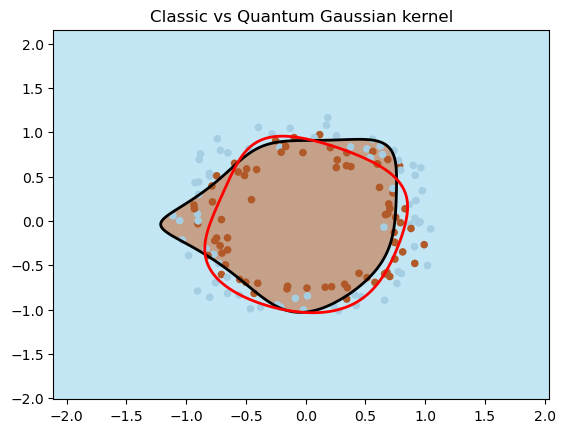

Best quantum (acc, auroc, auprc): [0.74666667 0.82008889 0.82681661]
Best quantum index among top-k: 19


In [ ]:
gamma = 1.0

# =========================
# (A) Classical: alpha 구하기 (cvxopt)
# =========================
P, q, G, h, A, b, Kc = CG.Solver_Parameter(N_train, X_train, y_train, gamma, C)
sol = CG.Solver_SVM(P, q, G, h, A, b)
alpha_c = np.ravel(sol['x'])  # (N_train,)

# test grid에서 classic decision surface
C_Z = CG.Test_Graph(X_test, X_train, y_train, y_test, alpha_c, Kc, gamma, C)  # 순서 중요!  :contentReference[oaicite:4]{index=4}


# =========================
# (B) Quantum: candidate alpha들 중 test 성능 최고 선택
# =========================
Kq, Q = QG.Q_metric(N_train, X_train, y_train, B, K, xi, gamma)
solset = QG.neal_Solver(Q)

alphas = []
metrics = []  # (acc, auroc, auprc)

top_k = 20
for n_th in range(top_k):
    x_opt, energy = QG.Solution(solset, top_k=top_k, n_th=n_th)
    alpha_q = QG.alpha_value(N_train, x_opt, B, K)
    alphas.append(alpha_q)

    scores_test = QG.Test_evlauation(X_train, X_test, y_train, alpha_q, Kq, gamma, C)
    acc, auroc, auprc = QG.evaluate_test(y_test, scores_test)
    metrics.append((acc, auroc, auprc))

metrics = np.array(metrics)  # shape (top_k, 3)

# “가장 분리가 잘됨”의 기준을 정해야 함:
# 예: AUROC 최대
best_idx = int(np.argmax(metrics[:, 1]))
Good_alpha = alphas[best_idx]

# test grid에서 quantum decision surface
Q_Z = QG.Test_Graph(X_train, X_test, y_train, y_test, Good_alpha, Kq, gamma, C)  # 순서 중요! :contentReference[oaicite:5]{index=5}


# =========================
# (C) Overlap plot (same axes)
# =========================
# 배경은 classic의 Z로 칠하고, 경계선 2개를 겹친다.
# (원하면 배경 없이 선만 겹쳐도 됨)

# classic Z로 contourf를 쓰려면 levels도 C_Z 기준으로 잡는 게 안전
plt.contourf(xx, yy, C_Z, levels=[C_Z.min(), 0, C_Z.max()],
             colors=['#87CEEB', '#8B4513'], alpha=0.5)

plt.contour(xx, yy, C_Z, levels=[0], colors='k', linewidths=2, label='Classic')
plt.contour(xx, yy, Q_Z, levels=[0], colors='r', linewidths=2, label='Quantum')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, s=20)
plt.title('Classic vs Quantum Gaussian kernel')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

print("Best quantum (acc, auroc, auprc):", metrics[best_idx])
print("Best quantum index among top-k:", best_idx)

In [ ]:
# fig, ax1 = plt.subplots()

# ax1.plot(
#     C_x, C_acc_list,
#     marker='s', linestyle='--',
#     color='tab:blue',
#     label="Classic_Accuracy"
# )
# ax1.set_ylim(0, 1)
# ax1.set_xticks(C_x, C_x_labels, rotation=90)
# ax1.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# ax2 = ax1.twiny()

# ax2.plot(
#     Q_x, acc_Max,
#     marker='o', linestyle='--',
#     color='tab:orange',
#     label="Quantum_Accuracy"
# )
# ax2.set_ylim(0, 1)
# ax2.set_xticks(Q_x, Q_x_labels, rotation=90)
# ax2.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()

# ax1.legend(
#     lines1 + lines2,
#     labels1 + labels2,
#     loc="lower left"
# )

# plt.show()

In [ ]:
# fig, ax1 = plt.subplots()

# ax1.plot(
#     C_x, C_auroc_list,
#     marker='s', linestyle='--',
#     color='tab:blue',
#     label="Classic_AUROC"
# )
# ax1.set_ylim(0, 1)
# ax1.set_xticks(C_x, C_x_labels, rotation=90)
# ax1.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# ax2 = ax1.twiny()

# ax2.plot(
#     Q_x, auroc_Max,
#     marker='o', linestyle='--',
#     color='tab:orange',
#     label="Quantum_AUROC"
# )
# ax2.set_ylim(0, 1)
# ax2.set_xticks(Q_x, Q_x_labels, rotation=90)
# ax2.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()

# ax1.legend(
#     lines1 + lines2,
#     labels1 + labels2,
#     loc="lower left"
# )

# plt.show()

In [ ]:
# fig, ax1 = plt.subplots()

# ax1.plot(
#     C_x, C_auprc_list,
#     marker='s', linestyle='--',
#     color='tab:blue',
#     label="Classic_AUPRC"
# )
# ax1.set_ylim(0, 1)
# ax1.set_xticks(C_x, C_x_labels, rotation=90)
# ax1.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# ax2 = ax1.twiny()

# ax2.plot(
#     Q_x, auprc_Max,
#     marker='o', linestyle='--',
#     color='tab:orange',
#     label="Quantum_AUPRC"
# )
# ax2.set_ylim(0, 1)
# ax2.set_xticks(Q_x, Q_x_labels, rotation=90)
# ax2.tick_params(axis = 'both', which='both', direction = "in", top = True, right = True)

# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()

# ax1.legend(
#     lines1 + lines2,
#     labels1 + labels2,
#     loc="lower left"
# )

# plt.show()